In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import sys

from tqdm import tqdm

In [4]:
config_file = "config_kdv.json"

with open(config_file, "r") as f:
    config = json.load(f)["linear"]

In [5]:
data_path = config["data_settings"]["data_path"]
weights_path = config["nn_settings"]["weights_path"]

n_traj = config["data_settings"]["n_traj"]
traj_len = config["data_settings"]["traj_len"]

# forcing_type = config['data_settings']['forcing_type']

forcing_type = "linear"


n_psi_train = config["nn_settings"]["n_psi_train"]
dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"]

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

2024-03-15 22:30:59.534468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 22:31:00.508289: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-15 22:31:04.701656: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:
2024-03-15 22:31:04.703015: W tensorflow/compiler/xla/stre

In [7]:
from koopmanlib.functions import *

In [8]:
from koopmanlib.target import KortewegDeVriesTarget

In [9]:
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
Nx = 128
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)
T = 0.01

In [10]:
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)

In [11]:
umax = 1
umin = -umax

target_dim = Nx
param_dim = 3

In [12]:
kdv = KortewegDeVriesTarget(
    x=x, t_step=T, dim=Nx, param_dim=param_dim, forcing_type="sin", v_list=v_list, L=L
)

In [13]:
dict_data = np.load(
    os.path.join(data_path, "data_kdv_" + forcing_type + ".npy"), allow_pickle=True
)

# Build model

## PK-NN

In [14]:
from tensorflow.keras.optimizers import Adam

from koopmanlib.dictionary import PsiNN_obs
from koopmanlib.param_solver import KoopmanParametricDLSolver

n_psi = 1 + 1 + 1 + n_psi_train  # constant + momentum + mean + NN

dic_pk = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

from koopmanlib.K_structure import Model_K_u_Layer_One

model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation="relu")

solver_pk = KoopmanParametricDLSolver(
    target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
)

model_pk, model_K_u_pred_pk = solver_pk.generate_model()

model_pk.load_weights(os.path.join(weights_path, "pk_kdv_weights_" + forcing_type + ".h5"))

2024-03-15 22:31:26.861970: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-03-15 22:31:26.862416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: neon
2024-03-15 22:31:26.862456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: neon
2024-03-15 22:31:26.863253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.239.6
2024-03-15 22:31:26.863383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.239.6
2024-03-15 22:31:26.863393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.239.6
2024-03-15 22:31:26.864943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep 

In [15]:
def compute_pk_obs(y0, param_list, B_obs):
    param = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
    y0 = y0.reshape(1, -1)

    psi_y = dic_pk(y0)
    obs_list = [psi_y @ B_obs]

    tau = param_list.shape[0]

    for i in range(tau):
        psi_y = model_K_u_pred_pk([param[i], psi_y])
        obs_next = psi_y @ B_obs
        obs_list.append(obs_next)

    return np.squeeze(np.asarray(obs_list))

## Linear

In [16]:
from koopmanlib.param_solver import KoopmanLinearDLSolver

dic_linear = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

solver_linear = KoopmanLinearDLSolver(
    dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
)

model_linear, model_K_u_pred_linear = solver_linear.build_model()

solver_linear.model.load_weights(
    os.path.join(weights_path, "linear_kdv_weights_" + forcing_type + ".h5")
)

In [17]:
def compute_linear_obs(y0, param_list, B_obs):
    param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
    y0 = y0.reshape(1, -1)
    psi_y = solver_linear.dic.call(y0)
    obs_list = [psi_y @ B_obs]

    for param in param_list:
        psi_y = solver_linear.model_K_u_pred_linear.get_layer("Layer_A")(psi_y) + solver_linear.model_K_u_pred_linear.get_layer(
            "Layer_B"
        )(param)
        obs_next = psi_y @ B_obs
        obs_list.append(obs_next)

    return np.squeeze(np.asarray(obs_list))

## Bilinear

In [18]:
from koopmanlib.param_solver import KoopmanBilinearDLSolver

dic_bilinear = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

solver_bilinear = KoopmanBilinearDLSolver(
    dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
)

model_bilinear, model_K_u_pred_bilinear = solver_bilinear.build_model()

In [19]:
solver_bilinear.model.load_weights(
    os.path.join(weights_path, "bilinear_kdv_weights_" + forcing_type + ".h5")
)

In [20]:
def compute_bilinear_obs(y0, param_list, B_obs):
    param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
    y0 = y0.reshape(1, -1)
    psi_y = solver_bilinear.dic.call(y0)
    obs_list = [psi_y @ B_obs]

    for param in param_list:
        u_psiy = tf.einsum("ij,ik->kij", psi_y, param)
        u_psiy_list = []
        for curr in u_psiy:
            u_psiy_list.append(curr)
        u_psiy_list = tf.concat(u_psiy_list, axis=-1)

        psi_y = solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_A")(
            psi_y
        ) + solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_B")(u_psiy_list)
        obs_next = psi_y @ B_obs
        obs_list.append(obs_next)

    return np.squeeze(np.asarray(obs_list))

# Testing problems

In [21]:
# Plot setting
linear_curve = "darkorange"
linear_shadow = "navajowhite"
bilinear_curve = "forestgreen"
bilinear_shadow = "darkseagreen"
pk_curve = "darkslateblue"
pk_shadow = "lightsteelblue"
ref_color = "black"


exact_color = "darkred"
linear_no_penalty_color = "gold"
bilinear_no_penalty_color = "turquoise"
pk_no_penalty_color = "palevioletred"

label_font = 24
ticks_font = 22
legend_font = 24
linewidth = 2.5
title_font = 16

linear_linestyle = "dashdot"
bilinear_linestyle = "dotted"
pk_linestyle = "solid"

## Prediction

In [22]:
def compute_kdv_soln(y0, param_list):
    y0_loop = y0
    kdv_soln_list = [y0_loop]
    for param in param_list:
        # Solve the equation using the scipy integrator
        soln = kdv.kdv_solution(y0_loop, T, param)
        y0_loop = soln.y.T[-1]
        kdv_soln_list.append(y0_loop)
    return kdv_soln_list

In [23]:
pred_traj_number = 5
np.random.seed(12)
seed_list = np.random.randint(low=1, high=200, size=(pred_traj_number, 2))

y0_pred_list = []
param_pred_list = []

Tsim_pred = 0.1
traj_len_pred = int(Tsim_pred / T)

for seed_IC, seed_u in seed_list:
    # Forward prediction problem setting
    y0_pred = kdv.generate_y0(seed_IC)

    # Set the seed of param_list
    np.random.seed(seed_u)

    param_pred = (
        np.random.uniform(low=0, high=1, size=(traj_len_pred, param_dim)) * (umax - umin) + umin
    )

    y0_pred_list.append(y0_pred)
    param_pred_list.append(param_pred)

In [24]:
error_mass_list_pk, error_momentum_list_pk = kdv.compute_obs_error(
    dic=dic_pk,
    compute_kdv_soln_func=compute_kdv_soln,
    compute_obs_func_model=compute_pk_obs,
    error_func=compute_diff_ratio_one_traj,
    y0_pred_list=y0_pred_list,
    param_pred_list=param_pred_list,
    dx=dx,
)

mass_mean_pk, mass_std_pk, mass_mean_plus_pk, mass_mean_minus_pk = compute_stat_info(
    error_mass_list_pk
)
momentum_mean_pk, momentum_std_pk, momentum_mean_plus_pk, momentum_mean_minus_pk = (
    compute_stat_info(error_momentum_list_pk)
)

In [25]:
error_mass_list_linear, error_momentum_list_linear = kdv.compute_obs_error(
    dic=dic_linear,
    compute_kdv_soln_func=compute_kdv_soln,
    compute_obs_func_model=compute_linear_obs,
    error_func=compute_diff_ratio_one_traj,
    y0_pred_list=y0_pred_list,
    param_pred_list=param_pred_list,
    dx=dx,
)
mass_mean_linear, mass_std_linear, mass_mean_plus_linear, mass_mean_minus_linear = (
    compute_stat_info(error_mass_list_linear)
)
(
    momentum_mean_linear,
    momentum_std_linear,
    momentum_mean_plus_linear,
    momentum_mean_minus_linear,
) = compute_stat_info(error_momentum_list_linear)

In [26]:
error_mass_list_bilinear, error_momentum_list_bilinear = kdv.compute_obs_error(
    dic=dic_bilinear,
    compute_kdv_soln_func=compute_kdv_soln,
    compute_obs_func_model=compute_bilinear_obs,
    error_func=compute_diff_ratio_one_traj,
    y0_pred_list=y0_pred_list,
    param_pred_list=param_pred_list,
    dx=dx,
)
mass_mean_bilinear, mass_std_bilinear, mass_mean_plus_bilinear, mass_mean_minus_bilinear = (
    compute_stat_info(error_mass_list_bilinear)
)
(
    momentum_mean_bilinear,
    momentum_std_bilinear,
    momentum_mean_plus_bilinear,
    momentum_mean_minus_bilinear,
) = compute_stat_info(error_momentum_list_bilinear)

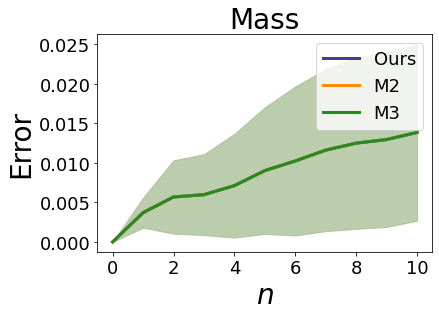

In [52]:
t_axis = np.arange(0, traj_len_pred + 1, 1)

plt.title("Mass", fontsize=28)
plt.plot(mass_mean_pk, label="Ours", color=pk_curve, linewidth=3)
plt.fill_between(
    t_axis, np.maximum(mass_mean_minus_pk, 0), mass_mean_plus_pk, color=pk_shadow, alpha=0.5
)

plt.plot(mass_mean_linear, label="M2", color=linear_curve, linewidth=3)
plt.fill_between(
    t_axis,
    np.maximum(mass_mean_minus_linear, 0),
    mass_mean_plus_linear,
    color=linear_shadow,
    alpha=0.5,
)

plt.plot(mass_mean_bilinear, label="M3", color=bilinear_curve, linewidth=3)
plt.fill_between(
    t_axis,
    np.maximum(mass_mean_minus_bilinear, 0),
    mass_mean_plus_bilinear,
    color=bilinear_shadow,
    alpha=0.5,
)

plt.xlabel(r"$n$", fontsize=28)
plt.ylabel("Error", fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

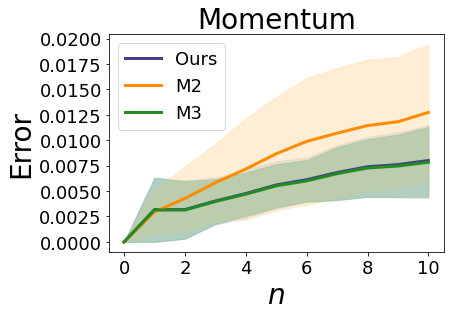

In [28]:
t_axis = np.arange(0, traj_len_pred + 1, 1)

plt.title("Momentum", fontsize=28)
plt.plot(momentum_mean_pk, label="Ours", color=pk_curve, linewidth=3)
plt.fill_between(
    t_axis,
    np.maximum(momentum_mean_minus_pk, 0),
    momentum_mean_plus_pk,
    color=pk_shadow,
    alpha=0.5,
)

plt.plot(momentum_mean_linear, label="M2", color=linear_curve, linewidth=3)
plt.fill_between(
    t_axis,
    np.maximum(momentum_mean_minus_linear, 0),
    momentum_mean_plus_linear,
    color=linear_shadow,
    alpha=0.5,
)

plt.plot(momentum_mean_bilinear, label="M3", color=bilinear_curve, linewidth=3)
plt.fill_between(
    t_axis,
    np.maximum(momentum_mean_minus_bilinear, 0),
    momentum_mean_plus_bilinear,
    color=bilinear_shadow,
    alpha=0.5,
)

plt.xlabel(r"$n$", fontsize=28)
plt.ylabel("Error", fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

# Tracking problem

In [29]:
from scipy.optimize import minimize

In [30]:
# Testing reference
y0_track = np.zeros(shape=(Nx,)) + 0.2

In [31]:
Tsim_track = 10

traj_len_track = int(Tsim_track / T)

### Set piece-wise reference
soln_ref = np.zeros(shape=(traj_len_track, target_dim)) + 0.3

for i in range(soln_ref.shape[0]):
    if i > traj_len_track / 2:
        soln_ref[i, :] = 0.5

In [32]:
mass_ref = dx * tf.reshape(tf.math.reduce_sum(soln_ref, axis=-1), shape=(-1, 1))
momentum_ref = dx * tf.reshape(tf.math.reduce_sum(tf.square(soln_ref), axis=-1), shape=(-1, 1))

In [33]:
def mpc_loss_pk(param, tau, ref_list, y0, B, lambda_param):
    param = tf.reshape(param, shape=(int(param.shape[0] / param_dim), 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1, -1)
    psi_y = dic_pk(y0)

    for i in range(tau):
        psi_x = model_K_u_pred_pk([param[i], psi_y])
        obs_next = psi_x @ B
        loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
        loss_list.append(loss_curr)

    ref_loss = tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

    loss = ref_loss + param_loss

    return loss


def mpc_loss_linear(param, tau, ref_list, y0, B, lambda_param):
    param = tf.reshape(param, shape=(int(param.shape[0] / param_dim), 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1, -1)
    psi_y = solver_linear.dic.call(y0)

    for i in range(tau):
        psi_y = solver_linear.model_K_u_pred_linear.get_layer("Layer_A")(psi_y) + solver_linear.model_K_u_pred_linear.get_layer(
            "Layer_B"
        )(param[i])
        obs = psi_y @ B
        loss_curr = tf.square(tf.norm(ref_list[i] - obs))
        loss_list.append(loss_curr)

    ref_loss = tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

    loss = ref_loss + param_loss

    return loss


def mpc_loss_bilinear(param, tau, ref_list, y0, B, lambda_param):
    param = tf.reshape(param, shape=(int(param.shape[0] / param_dim), 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1, -1)
    psi_y = solver_bilinear.dic.call(y0)

    for i in range(tau):

        u_psiy = tf.einsum("ij,ik->kij", psi_y, param[i])
        u_psiy_list = []
        for curr in u_psiy:
            u_psiy_list.append(curr)
        u_psiy_list = tf.concat(u_psiy_list, axis=-1)

        psi_y = solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_A")(
            psi_y
        ) + solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_B")(u_psiy_list)
        obs = psi_y @ B
        loss_curr = tf.square(tf.norm(ref_list[i] - obs))
        loss_list.append(loss_curr)

    ref_loss = tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

    loss = ref_loss + param_loss

    return loss

In [34]:
def KoopmanMPC(y0, tau, traj_len, soln_ref, kdv_solver, B, loss, lambda_param):

    bounds = []
    for i in range(tau * param_dim):
        bounds.append((-1, 1))

    y0_mpc_loop_list = [y0]
    opt_control_list = []

    # Wrap the loop with tqdm for a progress bar
    for current_time in tqdm(range(traj_len - tau - 1), desc="Processing time steps"):

        param_init = (
            np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin
        )

        results = minimize(
            loss,
            x0=param_init,
            args=(
                tau,
                soln_ref[current_time + 1 : current_time + 1 + tau, :],
                y0_mpc_loop_list[-1],
                B,
                lambda_param,
            ),
            bounds=bounds,
        )

        param = results.x.reshape(tau, param_dim)[0]
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param)

    current_time = current_time + 1

    param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin

    results = minimize(
        loss,
        x0=param_init,
        args=(
            tau,
            soln_ref[current_time + 1 : current_time + 1 + tau, :],
            y0_mpc_loop_list[-1],
            B,
            lambda_param,
        ),
        bounds=bounds,
    )

    param = results.x.reshape(tau, param_dim)
    for param_curr in param:
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param_curr)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param_curr)

    opt_control_list = np.asarray(opt_control_list)
    y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)

    return opt_control_list, y0_mpc_loop_list

In [35]:
B_mass = dic_pk.generate_B_mass(mass_ref)
B_momentum = dic_pk.generate_B_momentum(momentum_ref)

### Track mass

In [36]:
tau = 1  # time horizon
lambda_param = 0.005

In [37]:
pk_opt_control_mass, pk_kdv_opt_mass_soln = KoopmanMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=mass_ref,
    kdv_solver=kdv.kdv_solution,
    B=B_mass,
    loss=mpc_loss_pk,
    lambda_param=lambda_param,
)

Processing time steps: 100%|██████████| 998/998 [27:30<00:00,  1.65s/it]


In [38]:
linear_opt_control_mass, linear_kdv_opt_mass_soln = KoopmanMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=mass_ref,
    kdv_solver=kdv.kdv_solution,
    B=B_mass,
    loss=mpc_loss_linear,
    lambda_param=lambda_param,
)

Processing time steps:   1%|          | 12/998 [00:16<22:46,  1.39s/it]

Processing time steps: 100%|██████████| 998/998 [23:20<00:00,  1.40s/it]


In [39]:
bilinear_opt_control_mass, bilinear_kdv_opt_mass_soln = KoopmanMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=mass_ref,
    kdv_solver=kdv.kdv_solution,
    B=B_mass,
    loss=mpc_loss_bilinear,
    lambda_param=lambda_param,
)

Processing time steps:   4%|▍         | 38/998 [00:53<19:50,  1.24s/it]

Processing time steps: 100%|██████████| 998/998 [24:49<00:00,  1.49s/it]


In [40]:
pk_kdv_opt_mass = dx * tf.reduce_sum(pk_kdv_opt_mass_soln, axis=-1)
linear_kdv_opt_mass = dx * tf.reduce_sum(linear_kdv_opt_mass_soln, axis=-1)
bilinear_kdv_opt_mass = dx * tf.reduce_sum(bilinear_kdv_opt_mass_soln, axis=-1)

### Check exact control for KdV equation

In [41]:
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)


def v1_func(x):
    return np.exp(-25 * (x + np.pi / 2) ** 2)


def v2_func(x):
    return np.exp(-25 * (x) ** 2)


def v3_func(x):
    return np.exp(-25 * (x - np.pi / 2) ** 2)


from scipy import integrate

integral_1, error_1 = integrate.quad(v1_func, -np.pi, np.pi)

integral_2, error_2 = integrate.quad(v2_func, -np.pi, np.pi)

integral_3, error_3 = integrate.quad(v3_func, -np.pi, np.pi)

rhs_value = integral_1 + integral_2 + integral_3

mass_y0_track = dx * tf.reshape(tf.math.reduce_sum(y0_track, axis=-1), shape=(-1, 1))

track_time_1 = (mass_ref[0] - mass_y0_track) / rhs_value
track_step_1 = int(track_time_1 / T)

track_time_2 = (mass_ref[-1] - mass_ref[0]) / rhs_value
track_step_2 = int(track_time_2 / T)

control_exact_opt = np.zeros(shape=pk_opt_control_mass.shape, dtype="float64")

control_exact_opt[:track_step_1] = 0.5
control_exact_opt[500 : 500 + track_step_2] = 0.5

kdv_opt_control = compute_kdv_soln(y0_track, control_exact_opt)

kdv_opt_control = np.asarray(kdv_opt_control)
kdv_opt_mass = dx * tf.reshape(tf.math.reduce_sum(kdv_opt_control, axis=-1), shape=(-1, 1))

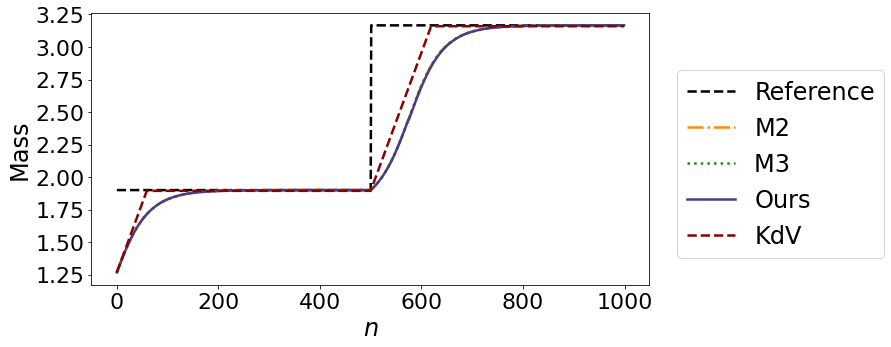

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(mass_ref, label="Reference", linestyle="--", color=ref_color, linewidth=linewidth)

plt.plot(
    linear_kdv_opt_mass,
    label="M2",
    color=linear_curve,
    linestyle=linear_linestyle,
    linewidth=linewidth,
)
plt.plot(
    bilinear_kdv_opt_mass,
    label="M3 ",
    color=bilinear_curve,
    linestyle=bilinear_linestyle,
    linewidth=linewidth,
)
plt.plot(
    pk_kdv_opt_mass, label="Ours", color=pk_curve, linestyle=pk_linestyle, linewidth=linewidth
)


plt.plot(kdv_opt_mass, label="KdV", linestyle="--", color=exact_color, linewidth=linewidth)

plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r"$n$", fontsize=label_font)
plt.ylabel("Mass", fontsize=label_font)
# plt.yscale('log')
plt.legend(fontsize=legend_font, loc=(1.05, 0.1))

### Track momentum

In [43]:
pk_opt_control_momentum, pk_kdv_opt_momentum_soln = KoopmanMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    B=B_momentum,
    loss=mpc_loss_pk,
    lambda_param=lambda_param,
)

Processing time steps:   1%|          | 9/998 [00:16<28:28,  1.73s/it]

Processing time steps: 100%|██████████| 998/998 [28:05<00:00,  1.69s/it]


In [44]:
linear_opt_control_momentum, linear_kdv_opt_momentum_soln = KoopmanMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    B=B_momentum,
    loss=mpc_loss_linear,
    lambda_param=lambda_param,
)

Processing time steps:   1%|          | 6/998 [00:09<26:15,  1.59s/it]

Processing time steps: 100%|██████████| 998/998 [24:53<00:00,  1.50s/it]


In [45]:
bilinear_opt_control_momentum, bilinear_kdv_opt_momentum_soln = KoopmanMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    B=B_momentum,
    loss=mpc_loss_bilinear,
    lambda_param=lambda_param,
)

Processing time steps:   1%|          | 9/998 [00:13<25:41,  1.56s/it]

Processing time steps: 100%|██████████| 998/998 [24:54<00:00,  1.50s/it]


In [46]:
pk_kdv_opt_momentum = dx * tf.reduce_sum(tf.square(pk_kdv_opt_momentum_soln), axis=-1)
linear_kdv_opt_momentum = dx * tf.reduce_sum(tf.square(linear_kdv_opt_momentum_soln), axis=-1)
bilinear_kdv_opt_momentum = dx * tf.reduce_sum(tf.square(bilinear_kdv_opt_momentum_soln), axis=-1)

In [1]:
plt.figure(figsize=(10, 5))
plt.plot(momentum_ref, label="Reference", linestyle="--", color=ref_color, linewidth=linewidth)

plt.plot(
    linear_kdv_opt_momentum,
    label="M2",
    color=linear_curve,
    linestyle=linear_linestyle,
    linewidth=linewidth,
)
plt.plot(
    bilinear_kdv_opt_momentum,
    label="M3 ",
    color=bilinear_curve,
    linestyle=bilinear_linestyle,
    linewidth=linewidth,
)
plt.plot(
    pk_kdv_opt_momentum, label="Ours", color=pk_curve, linestyle=pk_linestyle, linewidth=linewidth
)


plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r"$n$", fontsize=label_font)
plt.ylabel("momentum", fontsize=label_font)
plt.legend(fontsize=legend_font, loc=(1.05, 0.1))

NameError: name 'plt' is not defined

# Controllability

In [ ]:
# Randomly sample control
np.random.seed(seed=111)
n_control_samples = 2000
control_samples = (
    np.random.uniform(low=0, high=1, size=(n_control_samples, param_dim)) * (umax - umin) + umin
)

In [ ]:
pk_K_matrix = solver_pk.model_K_u(control_samples)

In [ ]:
identity_matrix = np.eye(N=pk_K_matrix.shape[-1])

pk_A_matrix = (pk_K_matrix - identity_matrix) / T

pk_A_vector = tf.reshape(
    pk_A_matrix, shape=(pk_A_matrix.shape[0], pk_A_matrix.shape[-1] * pk_A_matrix.shape[-1])
)

rank = np.linalg.matrix_rank(pk_A_vector)

U, S, VT = np.linalg.svd(pk_A_vector)

In [ ]:
pk_A_vector.shape

In [ ]:
np.sum(S > 1e-5)

In [ ]:
label_font = 16
ticks_font = 16

np.linspace(1, 36, 8)

# plt.plot(S, linewidth=2)
plt.plot(S / np.max(S), linewidth=2)


plt.yscale("log")

custom_xticks = np.linspace(1, 36, 8)
plt.xticks(custom_xticks, fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)


plt.xlabel(r"$i$", fontsize=label_font)
plt.ylabel(r"$\sigma_{i}$", fontsize=label_font)

# Save data

In [ ]:
# results_dict = {'eigen_value': S,
#                'pk_opt_soln_mass':pk_kdv_opt_mass,
#                'pk_opt_soln_momentum': pk_kdv_opt_momentum}

In [ ]:
# np.save(os.path.join(data_path,'K_layer/results_klayer'+str(K_layer_size[-1])+'.npy'), results_dict)

# Evaluation over different K structures
If you have solved the tracking problems over different K settings and saved results by the corresponding file name, you can run the following code to see the comparison. 

In [ ]:
results_dict_6 = np.load(os.path.join(data_path, "K_layer/results_klayer6.npy"), allow_pickle=True)

eig_value_6 = results_dict_6[()]["eigen_value"]
pk_opt_soln_mass_6 = results_dict_6[()]["pk_opt_soln_mass"]
pk_opt_soln_momentum_6 = results_dict_6[()]["pk_opt_soln_momentum"]

In [ ]:
results_dict_12 = np.load(
    os.path.join(data_path, "K_layer/results_klayer12.npy"), allow_pickle=True
)

eig_value_12 = results_dict_12[()]["eigen_value"]
pk_opt_soln_mass_12 = results_dict_12[()]["pk_opt_soln_mass"]
pk_opt_soln_momentum_12 = results_dict_12[()]["pk_opt_soln_momentum"]

In [ ]:
results_dict_36 = np.load(
    os.path.join(data_path, "K_layer/results_klayer36.npy"), allow_pickle=True
)

eig_value_36 = results_dict_36[()]["eigen_value"]
pk_opt_soln_mass_36 = results_dict_36[()]["pk_opt_soln_mass"]
pk_opt_soln_momentum_36 = results_dict_36[()]["pk_opt_soln_momentum"]

# Eigenvalues

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(eig_value_6, linewidth=2, label=r"$N_{K}$=7", marker="o", color="palevioletred")
plt.plot(eig_value_12, linewidth=2, label=r"$N_{K}$=13", marker="s", color="darkseagreen")
plt.plot(eig_value_36, linewidth=2, label=r"$N_{K}$=37", marker="*", color="darkorange")

plt.yscale("log")

custom_xticks = np.linspace(1, 36, 8)
plt.xticks(custom_xticks, fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)

# plt.xlim(0,37)
plt.ylim(1e-14, 1e5)
plt.xlabel(r"$i$", fontsize=22)
plt.ylabel(r"$\sigma_{i}$", fontsize=22)
plt.legend(fontsize=22, loc=(0.58, 0.2))

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(
    eig_value_6 / np.max(eig_value_6),
    linewidth=2,
    label=r"$N_{K}$=7",
    marker="o",
    color="palevioletred",
)
plt.plot(
    eig_value_12 / np.max(eig_value_12),
    linewidth=2,
    label=r"$N_{K}$=13",
    marker="s",
    color="darkseagreen",
)
plt.plot(
    eig_value_36 / np.max(eig_value_36),
    linewidth=2,
    label=r"$N_{K}$=37",
    marker="*",
    color="darkorange",
)

plt.yscale("log")

custom_xticks = np.linspace(1, 36, 8)
plt.xticks(custom_xticks, fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)

# plt.xlim(0,37)
# plt.ylim(1e-14,1e5)
plt.xlabel(r"$i$", fontsize=22)
plt.ylabel(r"$\sigma_{i}$", fontsize=22)
plt.legend(fontsize=22, loc=(0.58, 0.2))

In [ ]:
eig_value_36 / np.max(eig_value_36)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(mass_ref, label="Reference", linestyle="--", color=ref_color, linewidth=2)

plt.plot(pk_opt_soln_mass_6, linewidth=2, label=r"$N_{K}$=7", color="palevioletred")
plt.plot(pk_opt_soln_mass_12, linewidth=2, label=r"$N_{K}$=13", color="darkseagreen")
plt.plot(pk_opt_soln_mass_36, linewidth=2, label=r"$N_{K}$=37", color="darkorange")

plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)

plt.xlabel(r"$n$", fontsize=22)
plt.ylabel("Mass", fontsize=22)
plt.legend(fontsize=22)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(momentum_ref, label="Reference", linestyle="--", color=ref_color, linewidth=2)

plt.plot(pk_opt_soln_momentum_6, linewidth=2, label=r"$N_{K}$=7", color="palevioletred")
plt.plot(pk_opt_soln_momentum_12, linewidth=2, label=r"$N_{K}$=13", color="darkseagreen")
plt.plot(pk_opt_soln_momentum_36, linewidth=2, label=r"$N_{K}$=37", color="darkorange")


plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)

plt.xlabel(r"$n$", fontsize=22)
plt.ylabel("Momentum", fontsize=22)
plt.legend(fontsize=22)